In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import os

# Configure TensorFlow to use GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

df = pd.read_csv(r"C:\Users\abdel\Downloads\before.csv")

In [2]:
# Convert 'Label' column to string and then check for non-numeric characters
df['Label'] = df['Label'].astype(str)
df = df[~df['Label'].str.contains('[a-zA-Z]')]
# Convert the 'Label' column to integers
df['Label'] = pd.to_numeric(df['Label'], errors='coerce', downcast='integer')
df['Label'] = df['Label'].astype('float32')
# Drop rows with NaN values in 'Sentence' and 'Label' columns
df = df.dropna(subset=['Sentence', 'Label'])

# Check for NaN values after cleaning
print(df.isna().sum())

Sentence          0
Label             0
Unnamed: 2    30577
Unnamed: 3    30577
dtype: int64


In [6]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize the sentences
max_words = 10000  
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['Sentence'])
train_sequences = tokenizer.texts_to_sequences(train_data['Sentence'])
test_sequences = tokenizer.texts_to_sequences(test_data['Sentence'])

# Pad sequences to have the same length
max_sequence_length = 100  
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# RNN model
embedding_dim = 32  
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length),
    Bidirectional(LSTM(64, return_sequences=True)),  
    Dropout(0.5), 
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),  # Additional dense layer
    Dropout(0.5),  
    Dense(1, activation='sigmoid')  # Binary classification, so using sigmoid activation
])

In [7]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

labels_train = train_data['Label']
labels_test = test_data['Label']

model.fit(train_padded, labels_train, epochs=10, validation_data=(test_padded, labels_test), callbacks=[early_stopping])


# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_padded, labels_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Epoch 1/10
765/765 [==============================] - 50s 59ms/step - loss: 0.0729 - accuracy: 0.9760 - val_loss: 0.0285 - val_accuracy: 0.9953
Epoch 2/10
765/765 [==============================] - 41s 54ms/step - loss: 0.0220 - accuracy: 0.9963 - val_loss: 0.0247 - val_accuracy: 0.9953
Epoch 3/10
765/765 [==============================] - 40s 53ms/step - loss: 0.0209 - accuracy: 0.9963 - val_loss: 0.0244 - val_accuracy: 0.9941
Epoch 4/10
765/765 [==============================] - 41s 54ms/step - loss: 0.0155 - accuracy: 0.9968 - val_loss: 0.1159 - val_accuracy: 0.9897
Epoch 5/10
765/765 [==============================] - 43s 56ms/step - loss: 0.0141 - accuracy: 0.9973 - val_loss: 0.0349 - val_accuracy: 0.9918
Epoch 6/10
192/192 [==============================] - 5s 24ms/step - loss: 0.0244 - accuracy: 0.9941
Test Accuracy: 99.41%


192/192 [==============================] - 5s 22ms/step


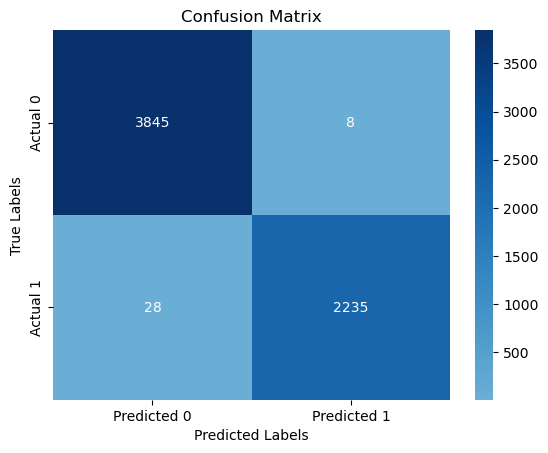

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3853
         1.0       1.00      0.99      0.99      2263

    accuracy                           0.99      6116
   macro avg       0.99      0.99      0.99      6116
weighted avg       0.99      0.99      0.99      6116



In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
# Predictions
y_pred_prob = model.predict(test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(labels_test, y_pred)

# Calculate TP, FP, TN, FN
tp = cm[1, 1]
fp = cm[0, 1]
tn = cm[0, 0]
fn = cm[1, 0]

# Create a DataFrame for better visualization
confusion_df = pd.DataFrame(
    data=[[tn, fp], [fn, tp]],
    index=['Actual 0', 'Actual 1'],
    columns=['Predicted 0', 'Predicted 1']
)

# Plot the heatmap
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', center=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(labels_test, y_pred))